# Modelling wolf, roe deer and wild boar population in the Netherlands

# 2 prey 1 predator model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy import signal, integrate, stats

In [2]:
# Coefficients for Lotka-volterra equations
alpha1 = 9/11  # Birth rate roe deer
beta1 = 0.631*4.86/365.25  # Death rate roe deer
gamma1 = 25/26  # Death rate wolf
delta1 = 0.00356*0.7*0.5  # Grow rate wolf based on roe deer
epsilon1 = 0.00356*0.3*0.5  # Grow rate predator based on wild board
eta1 = 4.56  # Brith rate wild boar
zeta1 = 5.8*0.6*4.86/365.25  # Death rate wild boar

# Time * step = amount of years
time = 36525  # Approx. amount of days in 100 years
step1 = 1/365.25  # 1 day

# Initial populations
init_wolf = 10
init_deer = 2500
init_boar = 500


def wolf_eq(gamma, delta, epsilon, w, r, z, step):
    """Differential equation for the wolf population."""
    return step * w * (-gamma + delta*r + epsilon*z)


def deer_eq(alpha, beta, w, r, step):
    """Differential equation for the roe deer population."""
    return step * r * (alpha - beta*w)


def boar_eq(eta, zeta, w, z, step):
    """Differential equation for the wild boar population."""
    return step * z * (eta - zeta*w)

In [3]:
def plot_figure(t, wolf, deer, boar, title, plot_prey, xy_lim):
    """Plot the animal populations with respect to the time."""
    plt.figure(figsize=(6, 4))
    plt.plot(t, wolf)
    legend_list = ['Wolf']

    if xy_lim:
        plt.axis([xy_lim[0], xy_lim[1], xy_lim[2], xy_lim[3]])

    if plot_prey:
        plt.plot(t, deer)
        plt.plot(t, boar)
        legend_list = ['Wolf', 'Roe deer', 'Wild boar']

    plt.ylabel('Number of animals')
    plt.xlabel('Time (years)')
    plt.title(title, fontsize=20)
    plt.legend(legend_list, loc='upper left')
    plt.show()

In [4]:
def setup_sliders(init_wolf, init_deer, init_boar, alpha1, beta1, gamma1,
                  delta1, epsilon1, eta1, zeta1, step1):
    """Setup the sliders for all the variables that affect the simulation."""
    iwolf_slider = widgets.IntSlider(value=init_wolf, min=0, max=100, step=1)
    ideer_slider = widgets.IntSlider(value=init_deer, min=0, max=5000, step=1)
    iboar_slider = widgets.IntSlider(value=init_boar, min=0, max=300, step=1)
    a1_slider = widgets.FloatSlider(value=alpha1, min=0, max=3, step=0.1)
    b1_slider = widgets.FloatSlider(value=beta1, min=0, max=3, step=0.1)
    g1_slider = widgets.FloatSlider(value=gamma1, min=0, max=3, step=0.1)
    d1_slider = widgets.FloatSlider(value=delta1, min=0, max=0.2, step=0.01)
    e1_slider = widgets.FloatSlider(value=epsilon1, min=0, max=0.2, step=0.01)
    et1_slider = widgets.FloatSlider(value=eta1, min=0, max=7, step=0.1)
    z1_slider = widgets.FloatSlider(value=zeta1, min=0, max=3, step=0.01)
    s1_slider = widgets.FloatSlider(value=step1, min=0, max=0.005, step=0.0001)
    period_slider = widgets.IntSlider(value=365, min=0, max=1095, step=1)
    pop_coef_slider = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01)
    scale_slider = widgets.IntSlider(value=1, min=1, max=100, step=1)
    plot_prey_checkbox = widgets.Checkbox(value=True, disabled=False)

    return [iwolf_slider, ideer_slider, iboar_slider,
            a1_slider, b1_slider, g1_slider, d1_slider,
            e1_slider, et1_slider, z1_slider, s1_slider,
            period_slider, pop_coef_slider, scale_slider, plot_prey_checkbox]

In [5]:
def verification(init_wolf, init_deer, init_boar, step1, per, pop_coef1,
                 shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey, severe_winter, introduce, xy_lim):
    """Produce plots for a particular situation to verify the model."""
    update(init_wolf, init_deer, init_boar, step1, per, pop_coef1,
           shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey, severe_winter, introduce, xy_lim)

In [6]:
def introduce_in_middle(n, introduce, num_deer, num_boar, num_wolf):
    """Introduce a specified number of animals after n timesteps."""
    if n == 500:
        if introduce == 'deer':
            num_deer = 3000
        elif introduce == 'boar':
            num_boar = 3000
        elif introduce == 'wolf':
            num_wolf = 300

    return [num_deer, num_boar, num_wolf]


def change_deers(shoot_deer, num_deer, pop_coeff, n, period, ddeer):
    """Change the number of roe deer according to the shoot settings."""
    # Shoot percentage of the deer every period.
    if shoot_deer == 'percentage' and (n % period == 0):
        num_deer *= pop_coeff

    # Shoot a set amount of the deer every period.
    elif shoot_deer == 'static' and (n % period == 0):
        if (num_deer > pop_coeff):
            num_deer -= pop_coeff
        else:
            num_deer = 0

    # Shoot a percentage of the growth every period.
    elif shoot_deer == 'dynamic' and (n % period == 0):
        num_deer -= ddeer * pop_coeff

    return num_deer


def change_boars(shoot_boar, n, period, num_boar, pop_coeff, dboar):
    """Change the number of wild boars according to the shoot settings."""
    # Shoot percentage of the boar every period.
    if shoot_boar == 'percentage' and (n % period == 0):
        num_boar *= pop_coeff

    # Shoot a set amount of the boar every period.
    elif shoot_boar == 'static' and (n % period == 0):
        if (num_boar > pop_coeff):
            num_boar -= pop_coeff
        else:
            num_boar = 0

    # Shoot a percentage of the growth every period.
    elif shoot_boar == 'dynamic' and (n % period == 0):
        num_boar -= dboar * pop_coeff

    return num_boar


def change_wolves(shoot_wolf, n, period, num_wolf, pop_coeff, introduce_wolf, dwolf):
    """Change the number of wolves according to the shoot and introduce settings."""
    # Shoot percentage of the wolf every period.
    if shoot_wolf == 'percentage' and (n % period == 0):
        num_wolf *= pop_coeff

    # Shoot a set amount of the wolf every period.
    elif shoot_wolf == 'static' and (n % period == 0):
        if (num_wolf > pop_coeff):
            num_wolf -= pop_coeff
        else:
            num_wolf = 0

    # Shoot a percentage of the growth every period.
    elif shoot_wolf == 'dynamic' and (n % period == 0):
        num_wolf -= dwolf * pop_coeff

    # gradual (monthly) introduction/increase of wolves.
    # Start with 1 wolf and comment
    if introduce_wolf and (n % period == 0):
        num_wolf *= pop_coeff

    return num_wolf


def start_winter(severe_winter, num_deer, num_boar, ddeer, dboar, pop_coeff, n, period):
    """Change the number of prey according to the severe winter settings."""
    # reduce growth during 90 days
    if severe_winter and (n % period < 90):
        num_deer -= ddeer * pop_coeff
        num_boar -= dboar * pop_coeff

    return [num_deer, num_boar]

In [7]:
def lotka_volterra(params, alpha1=alpha1, beta1=beta1, gamma1=gamma1,
                   delta1=delta1, epsilon1=epsilon1, eta1=eta1, zeta1=zeta1):
    """Calculate the population numbers for the 3 species for a certain amount of time."""

    # Unpack paramters from params.
    init_wolf, init_deer, init_boar, step1, period, pop_coeff, shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, severe_winter, introduce = params
    # Initialize arrays for number of animals in populations
    wolf = [init_wolf]
    deer = [init_deer]
    boar = [init_boar]

    num_wolf = init_wolf
    num_deer = init_deer
    num_boar = init_boar

    # Update the number of animals time times and store them in arrays
    for n in range(time):
        dwolf = wolf_eq(gamma1, delta1, epsilon1, num_wolf, num_deer, num_boar, step1)
        ddeer = deer_eq(alpha1, beta1, num_wolf, num_deer, step1)
        dboar = boar_eq(eta1, zeta1, num_wolf, num_boar, step1)
        num_wolf += dwolf
        num_deer += ddeer
        num_boar += dboar

        # Following a couple of real life events that can occur.
        # Introduce animals in the middle of the simulation.
        num_deer, num_boar, num_wolf = introduce_in_middle(n, introduce, num_deer, num_boar, num_wolf)

        # Change the roe deer population.
        num_deer = change_deers(shoot_deer, num_deer, pop_coeff, n, period, ddeer)

        # Change the wild boar population.
        num_boar = change_boars(shoot_boar, n, period, num_boar, pop_coeff, dboar)

        # Change the wolf population.
        num_wolf = change_wolves(shoot_wolf, n, period, num_wolf, pop_coeff, introduce_wolf, dwolf)

        # Change the growth of the prey populations to simulate a severe winter.
        num_deer, num_boar = start_winter(severe_winter, num_deer, num_boar, ddeer, dboar, pop_coeff, n, period)

        wolf.append(num_wolf)
        deer.append(num_deer)
        boar.append(num_boar)

    return [wolf, deer, boar]


def update(init_wolf, init_deer, init_boar, step1, period1, pop_coef1,
           shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title,
           scale, plot_prey, severe_winter, introduce, xy_lim):
    """Make and update the plot according to the variables that are set."""

    params = [init_wolf, init_deer, init_boar, step1, period1,
              pop_coef1, shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, severe_winter, introduce]

    results = lotka_volterra(params)

    wolf, deer, boar = results

    # Plot the figure.
    t = range(int((time + 1) / scale))
    t = [step1 * x /
         scale for x in t]

    # Correct dimensions of the list to prevent dimension
    # errors during plotting.
    last = int((len(wolf) - 1) / scale)
    if last > len(t):
        last -= 1
    elif last < len(t):
        last += 1

    plot_figure(t, wolf[0:last], deer[0:last], boar[0:last], title, plot_prey, xy_lim)


slider = setup_sliders(init_wolf, init_deer, init_boar,
                       alpha1, beta1, gamma1, delta1, epsilon1,
                       eta1, zeta1, step1)

widgets.interact_manual(update, init_wolf=slider[0], init_deer=slider[1], init_boar=slider[2], step1=slider[10],
                        period1=slider[11], pop_coef1=0.9,
                        shoot_deer=['none', 'percentage', 'static', 'dynamic'],
                        shoot_boar=['none', 'percentage', 'static', 'dynamic'],
                        shoot_wolf=['none', 'percentage', 'static', 'dynamic'],
                        introduce_wolf=False, title='Wolf-Roe deer-Wild boar model',
                        scale=slider[13], plot_prey=slider[14], severe_winter=False, introduce=False, xy_lim=[[0, 100, 0, 1000], False]);

interactive(children=(IntSlider(value=10, description='init_wolf'), IntSlider(value=2500, description='init_de…

In [8]:
def get_periodicity(data, height=150, index=0):
    """Returns the amount of peaks (periods) in data."""
    results = []

    for i in data:
        results.append(len(signal.find_peaks(i, height=height)[0]))

    return max(results)


def periodicity(index, x_range, params, reverse=False):
    """Calculate for different shooting coefficients the amount of periods in population size."""
    results = []

    for i in x_range:
        params[5] = i
        num_periods = get_periodicity(lotka_volterra(params))
        results.append(num_periods)

    if reverse:
        results.reverse()

    return results

In [9]:
def students_t_test(results, mean):
    """Perform a Student's one-sample t-test on the results with the specified mean."""
    return stats.ttest_1samp(results, mean)

In [10]:
def test_significance(results, mean):
    """Check if correlation is significant by performing a t-test and checking the resulting p value."""
    _, p = students_t_test(results, mean)
    significant = False

    # p < 0.05, null hypothesis rejected. Mean of results is significantly different from given mean.
    if p < 0.05:
        significant = True
    return significant

In [11]:
def make_scatter_plot(independant, dependant, independant_name, dependant_name):
    """Make a scatter plot with the given data and names."""
    plt.figure(figsize=(8, 6))
    plt.scatter(independant, dependant, c='b')
    plt.ylabel(dependant_name)
    plt.xlabel(independant_name)
    plt.title('Scatter plot of %s and %s' % (dependant_name, independant_name), fontsize=16)
    plt.show()

In [12]:
def average_amount_array(data_array, time_array):
    """Return the average amount of animals per year by dividing the area under the graph by 100."""
    area = integrate.simps(data_array, time_array)
    return area/100

In [13]:
def avg_animals_integrate(index, p_min, p_max, steps, params, t_array, type='per'):
    """Calculate for different shooting coefficients the average amount of animals per year."""
    results = []
    indep_var = np.linspace(p_min, p_max, steps+1)

    # Calculate the average amount of animals and append it to the results.
    for v in indep_var:
        if type == 'per':
            params[5] = 1 - (v / 100)
        elif type == 'num':
            params[5] = v
        avg_animals = average_amount_array(lotka_volterra(params)[index], t_array)
        results.append(avg_animals)

    return indep_var, results

In [14]:
def avg_animals_winters(p_min, p_max, steps, params, t_array, type='per'):
    """Calculate for different frequency of severe winters, the average amount of prey per year."""
    results = []
    periods = np.linspace(p_min, p_max, steps+1)

    # Calculate total average amount of prey if every p year 1 severe winter occurs.
    for p in periods:
        params[4] = p
        avg_roe = average_amount_array(lotka_volterra(params)[1], t_array)
        avg_boar = average_amount_array(lotka_volterra(params)[2], t_array)
        results.append(avg_roe + avg_boar)

    return periods, results

# Model Verification

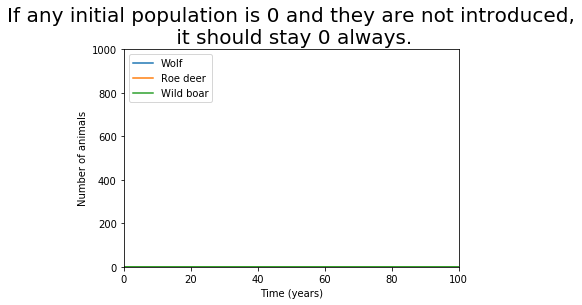

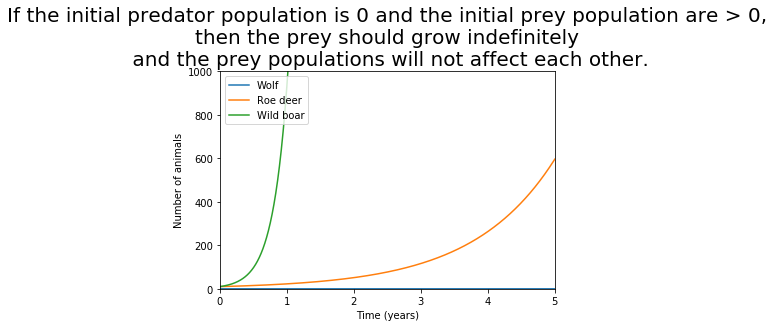

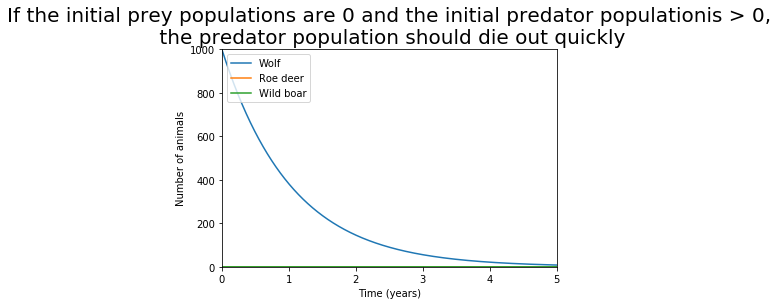

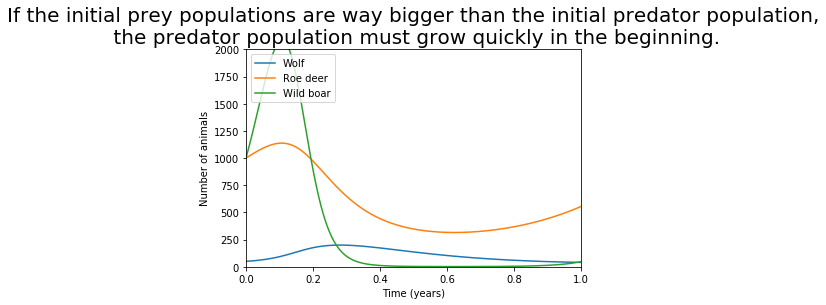

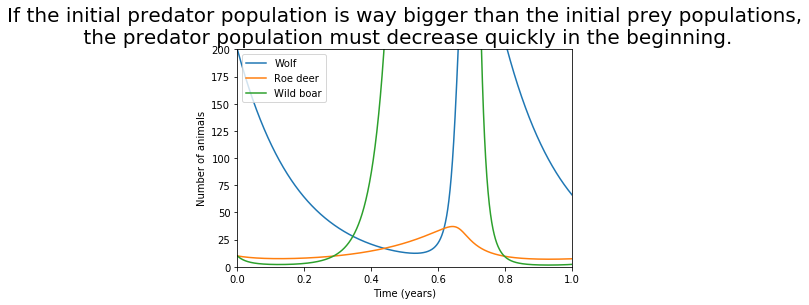

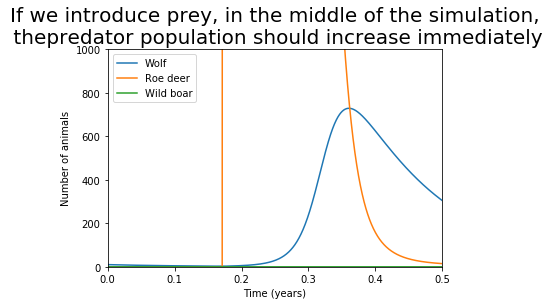

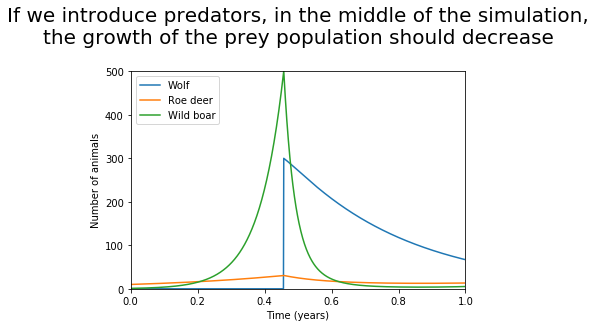

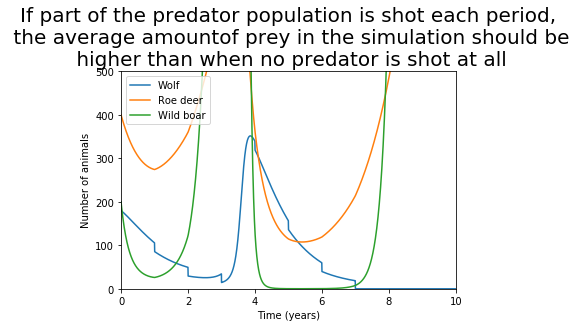

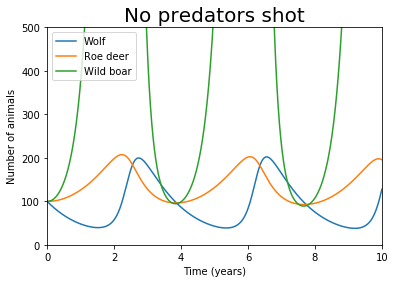

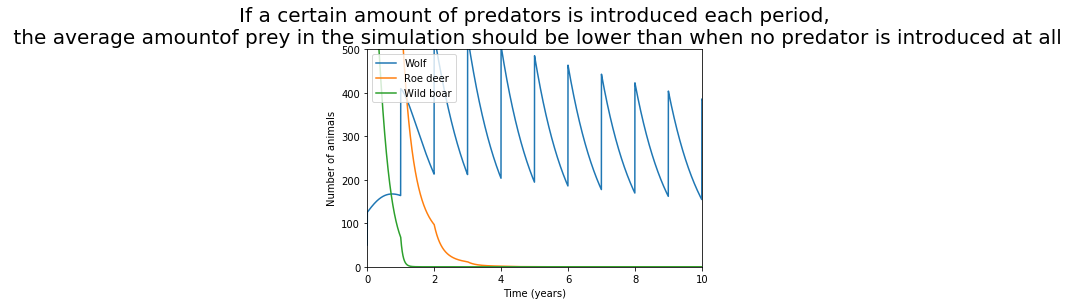

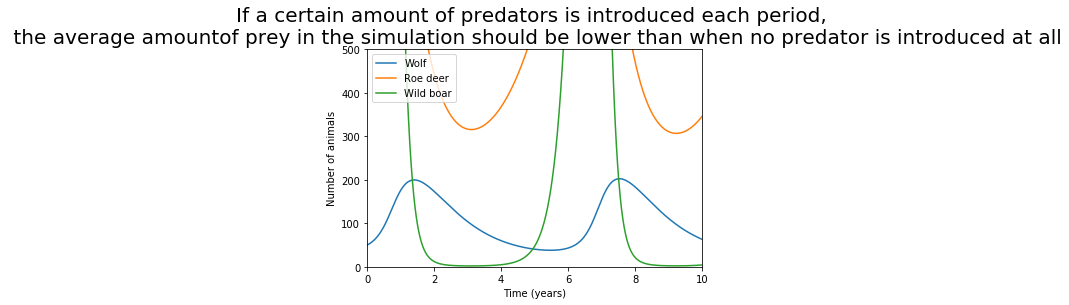

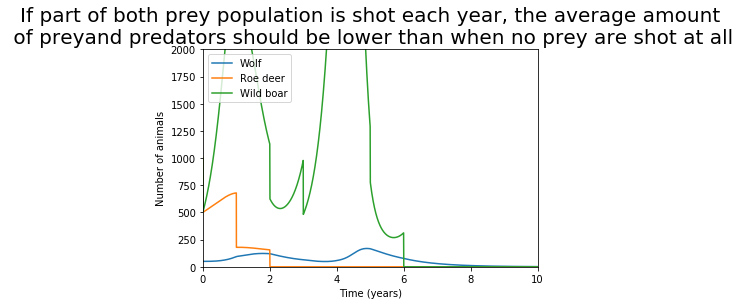

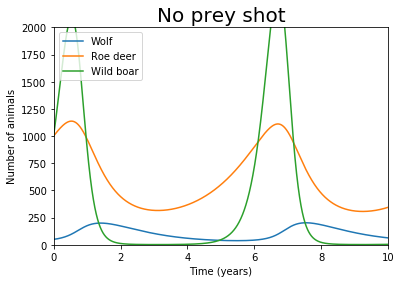

In [15]:
"""Verify the model by running functions with values from which the outcome is known"""
# If any initial population is 0 and they are not introduced, it should stay 0 always.
title = 'If any initial population is 0 and they are not introduced,\n it should stay 0 always.'
scale = 1
plot_prey = True
verification(0, 0, 0, step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 100, 0, 1000])

# If the initial predator population is 0 and the initial prey populations are > 0,
# then the prey should grow indefinitely.
title = ('If the initial predator population is 0 and the initial prey population are > 0,\n'
         'then the prey should grow indefinitely\n and the prey populations will not affect each other.')
verification(0, 10, 10, step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 5, 0, 1000])


title = ('If the initial prey populations are 0 and the initial predator population'
         'is > 0,\n the predator population should die out quickly')
# If the initial prey populations are 0 and the initial predator population is >0,
# the predator population should die out quickly (2 weeks[1])
verification(1000, 0, 0, step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 5, 0, 1000])


# If the initial prey populations are way bigger than the initial predator population,
# the predator population must grow quickly in the beginning.
title = ('If the initial prey populations are way bigger than the initial predator population,'
         '\n the predator population must grow quickly in the beginning.')
scale = 5
plot_prey = True
verification(50, 1000, 1000,  step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 1, 0, 2000])

# If the initial predator population is way bigger than the initial prey populations,
# the predator population must decrease quickly in the beginning.
title = ('If the initial predator population is way bigger than the initial prey '
         'populations,\n the predator population must decrease quickly in the beginning.')
scale = 6
plot_prey = True
verification(200, 10, 10, step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 1, 0, 200])

# If we introduce prey, in the middle of the simulation,
# the predator population should increase immediately
title = ('If we introduce prey, in the middle of the simulation,\n the'
         'predator population should increase immediately')
scale = 8
plot_prey = True
verification(10, 0, 0, step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             'deer', [0, 0.5, 0, 1000])

# If we introduce predators, in the middle of the simulation,
# the growth of the prey population should decrease
title = ('If we introduce predators, in the middle of the simulation,\n'
         'the growth of the prey population should decrease\n')
scale = 3
plot_prey = True
verification(0, 10, 1, step1, 365, 0.9,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             'wolf', [0, 1, 0, 500])

# If part of the predator population is shot each period,
# the average amount of prey in the simulation should be
# higher than when no predator is shot at all
title = ('If part of the predator population is shot each period,\n the average amount'
         'of prey in the simulation should be\n higher than when no predator is shot at all')
scale = 1
plot_prey = True
verification(200, 400, 200, step1, 365, 20,
             'none', 'none', 'static', False,
             title, scale, plot_prey, False,
             False, [0, 10, 0, 500])

# If part of the predator population is shot each period,
# the average amount of prey in the simulation should be
# higher than when no predator is shot at all
title = 'No predators shot'
scale = 1
plot_prey = True
verification(100, 100, 100, step1, 365, 0,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 10, 0, 500])

# If a certain amount of predators is introduced each period, the average amount
# of prey in the simulation should be lower than when no predator is introduced at all
title = ('If a certain amount of predators is introduced each period,\n the average amount'
         'of prey in the simulation should be lower than when no predator is introduced at all')
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 2.5,
             'none', 'none', 'none', True,
             title, scale, plot_prey, False,
             False, [0, 10, 0, 500])

# If a certain amount of predators is introduced each period, the average amount
# of prey in the simulation should be lower than when no predator is introduced at all
title = ('If a certain amount of predators is introduced each period, \n the average amount'
         'of prey in the simulation should be lower than when no predator is introduced at all')
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 0,
             'none', 'none', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 10, 0, 500])

# If part of both prey population is shot each year, the average amount of prey
# and predators should be lower than when no prey are shot at all
title = ('If part of both prey population is shot each year, the average amount\n of prey'
         'and predators should be lower than when no prey are shot at all')
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 500,
             'static', 'static', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 10, 0, 2000])

title = 'No prey shot'
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 0,
             'static', 'static', 'none', False,
             title, scale, plot_prey, False,
             False, [0, 10, 0, 2000])

# Model validation

The amount of periods without any events is  10  periods.


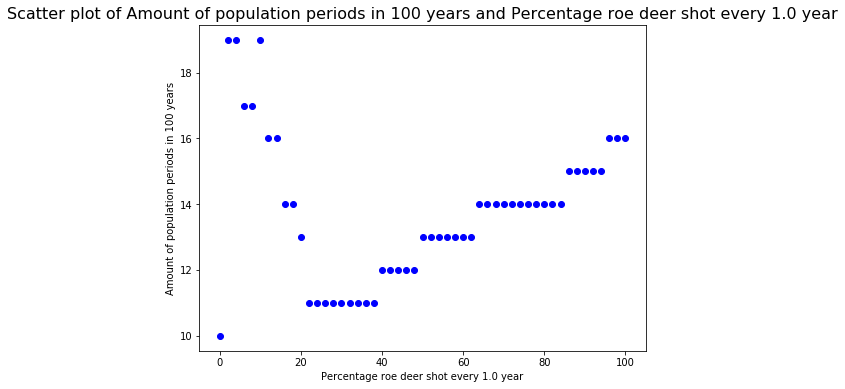

Significant correlation? True


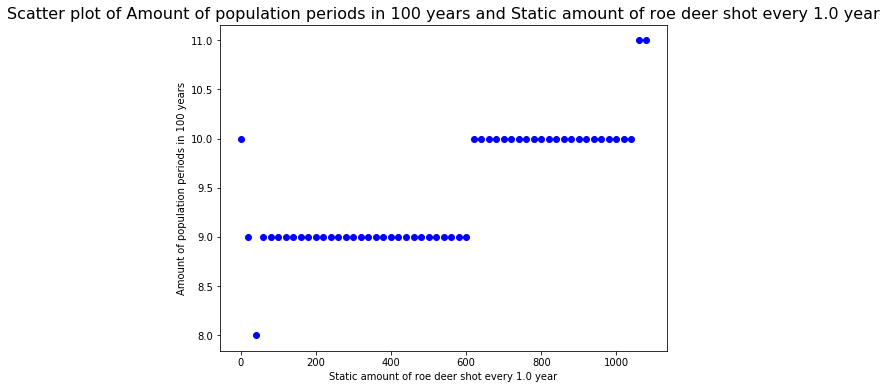

Significant correlation? True


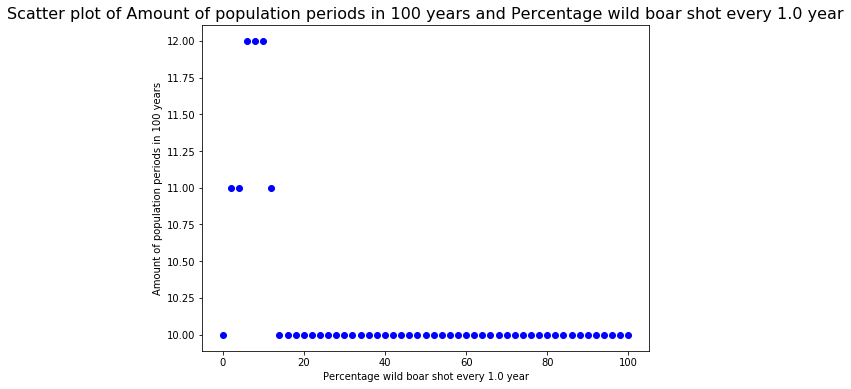

Significant correlation? True


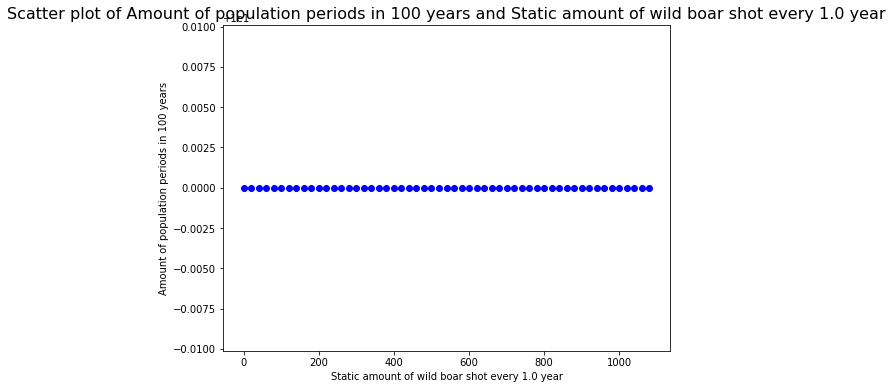

Significant correlation? False


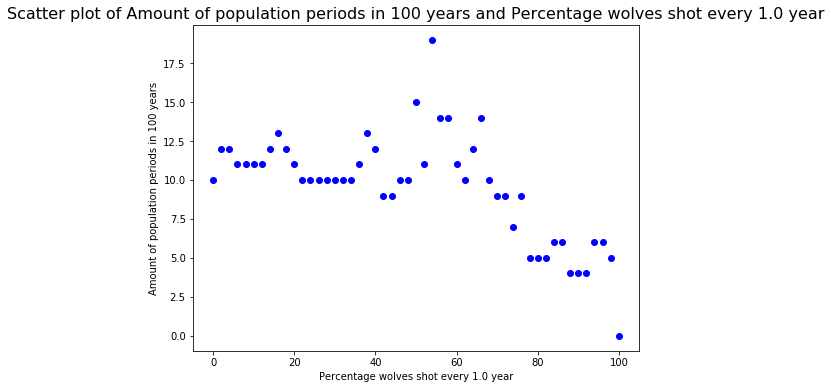

Significant correlation? False


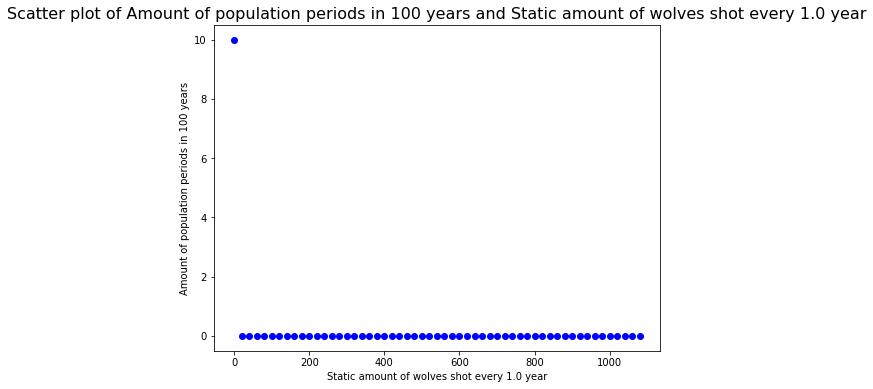

Significant correlation? True


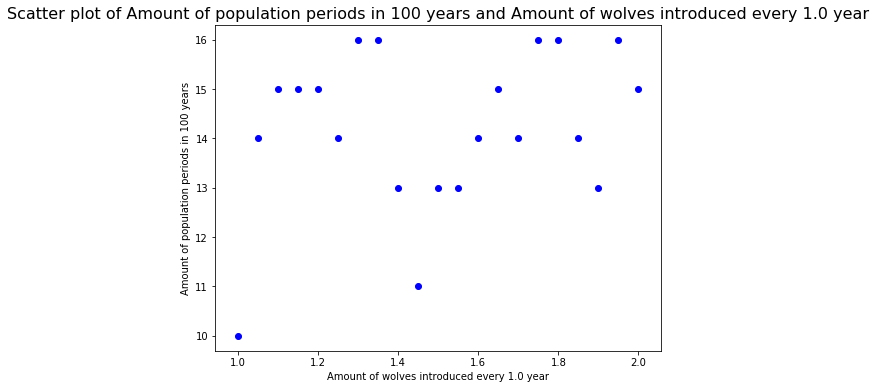

Significant correlation? True


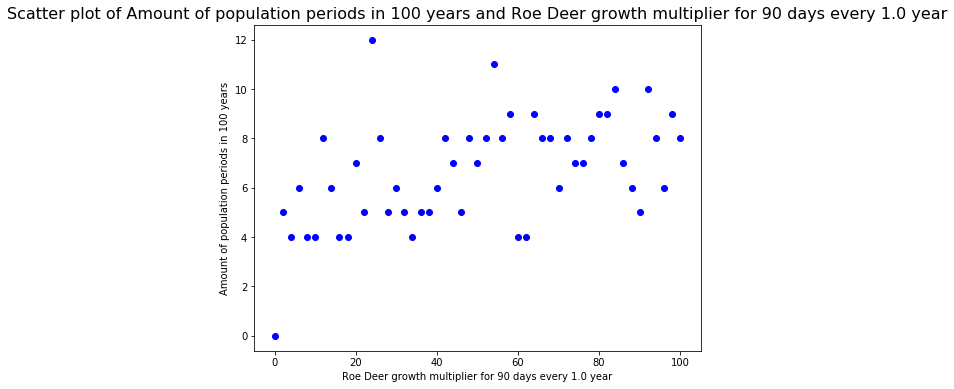

Significant correlation? True


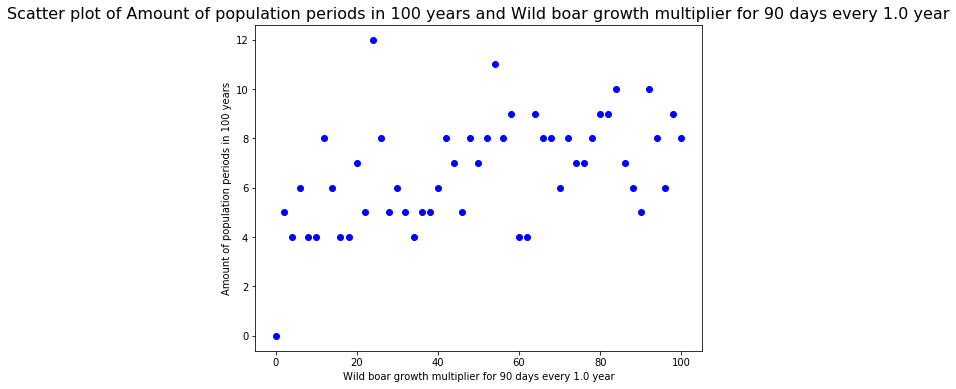

Significant correlation? True


In [16]:
params = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', False, False, False]

# Results without any alterations
mean_r = periodicity(0, [0], params)
print('The amount of periods without any events is ', mean_r[0], ' periods.')

# Deer shooting

# shoot percentage of deer
params[6] = 'percentage'
spod_results = periodicity(1, np.arange(0, 1.02, 0.02), params, True)
make_scatter_plot(np.arange(0, 102, 2), spod_results,
                  'Percentage roe deer shot every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(spod_results, mean_r[0]))

# shoot set amount of deer
params[6] = 'static'
ssaod_results = periodicity(1, np.arange(0, 1100, 20), params, False)
params[6] = 'none'
make_scatter_plot(np.arange(0, 1100, 20), ssaod_results,
                  'Static amount of roe deer shot every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(ssaod_results, mean_r[0]))

# Wild boar shooting

# shoot percentage of wild boar
params[7] = 'percentage'
spowb_results = periodicity(2, np.arange(0, 1.02, 0.02), params, True)
make_scatter_plot(np.arange(0, 102, 2), spowb_results,
                  'Percentage wild boar shot every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(spowb_results, mean_r[0]))

# shoot set amount of wild boar
params[7] = 'static'
ssaowb_results = periodicity(2, np.arange(0, 1100, 20), params, False)
params[7] = 'none'
make_scatter_plot(np.arange(0, 1100, 20), ssaowb_results,
                  'Static amount of wild boar shot every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(ssaowb_results, mean_r[0]))


# Wolf shooting

# shoot percentage of wolves
params[8] = 'percentage'
spow_results = periodicity(2, np.arange(0, 1.02, 0.02), params, True)
make_scatter_plot(np.arange(0, 102, 2), spow_results,
                  'Percentage wolves shot every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(spow_results, mean_r[0]))

# shoot set amount of wolves
params[8] = 'static'
ssaow_results = periodicity(2, np.arange(0, 1100, 20), params, False)
params[8] = 'none'
make_scatter_plot(np.arange(0, 1100, 20), ssaow_results,
                  'Static amount of wolves shot every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(ssaow_results, mean_r[0]))


# introduce set amount of wolves
params[9] = 'True'
iw_results = periodicity(0, np.arange(1, 2.05, 0.05), params, False)
params[9] = 'False'
make_scatter_plot(np.arange(1, 2.05, 0.05), iw_results,
                  'Amount of wolves introduced every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(iw_results, mean_r[0]))


# severe winters
params[10] = 'True'
swd_results = periodicity(1, np.arange(0, 1.02, 0.02), params)
swb_results = periodicity(2, np.arange(0, 1.02, 0.02), params)
params[10] = 'False'
make_scatter_plot(np.arange(0, 102, 2), swd_results,
                  'Roe Deer growth multiplier for 90 days every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(swd_results, mean_r[0]))

make_scatter_plot(np.arange(0, 102, 2), swb_results,
                  'Wild boar growth multiplier for 90 days every %s year' % str(params[4]/365.25),
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(swb_results, mean_r[0]))

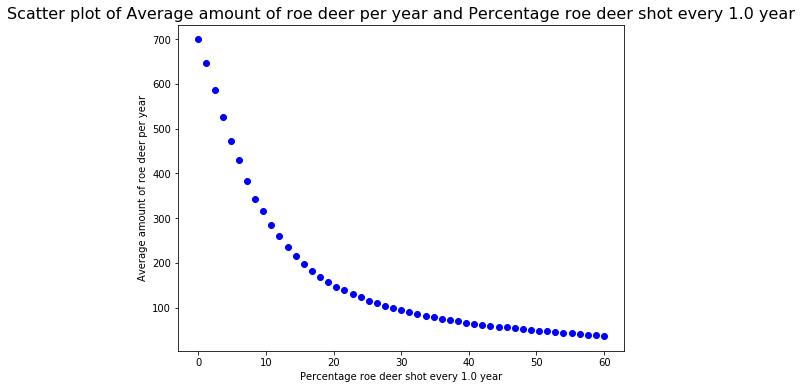

Significant correlation? True


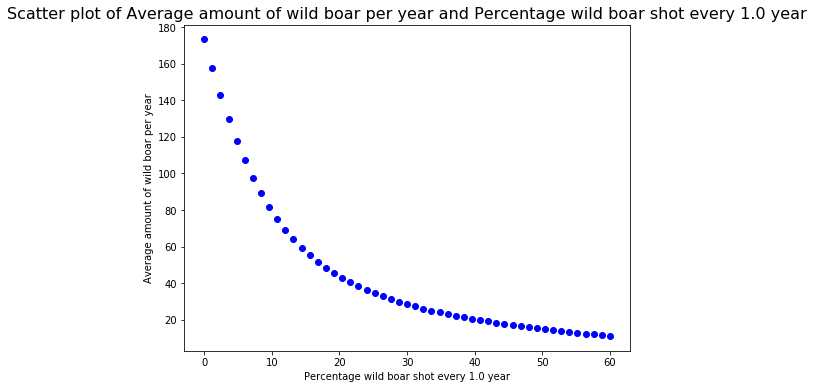

Significant correlation? True


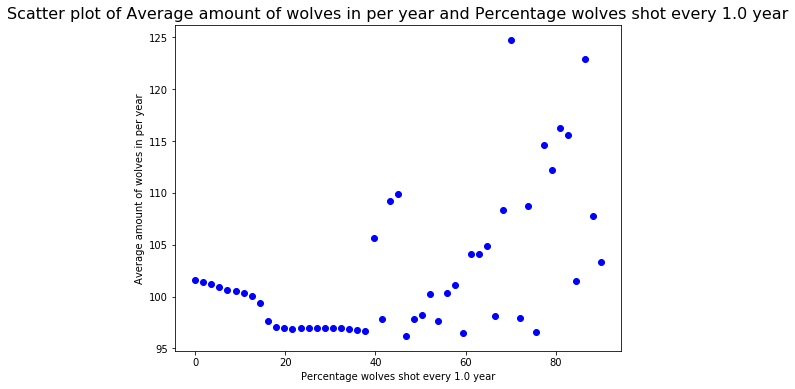

Significant correlation? False


In [17]:
# Make time array so integral can be calculated.
t = range(int(36526))
t = [step1*x for x in t]

# Calculate average amount of animals if no events happen.
params_noevents = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', False, False, False]
wolf_array, deer_array, boar_array = lotka_volterra(params_noevents)
mean_wolf = average_amount_array(wolf_array, t)
mean_deer = average_amount_array(deer_array, t)
mean_boar = average_amount_array(boar_array, t)

# Make the parameters for the lotka-volterra function for percentages of animals shot.
params_per = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', False, False, False]

# Make data points for the different species.
params_per[6] = 'percentage'
per_r, res_r = avg_animals_integrate(1, 0, 60, 50, params_per, t)  # Roe deer
params_per[6] = 'none'
params_per[7] = 'percentage'
per_b, res_b = avg_animals_integrate(2, 0, 60, 50, params_per, t)  # Wild boar
params_per[7] = 'none'
params_per[8] = 'percentage'
per_w, res_w = avg_animals_integrate(0, 0, 90, 50, params_per, t)  # Wolves

# Make scatter plots for the different species and check the significance of the correlation.
make_scatter_plot(per_r, res_r, 'Percentage roe deer shot every %s year' % str(params_per[4]/365.25),
                  'Average amount of roe deer per year')
print('Significant correlation? %s' % test_significance(res_r, mean_deer))

make_scatter_plot(per_b, res_b, 'Percentage wild boar shot every %s year' % str(params_per[4]/365.25),
                  'Average amount of wild boar per year')
print('Significant correlation? %s' % test_significance(res_b, mean_boar))

make_scatter_plot(per_w, res_w, 'Percentage wolves shot every %s year' % str(params_per[4]/365.25),
                  'Average amount of wolves in per year')
print('Significant correlation? %s' % test_significance(res_w, mean_wolf))

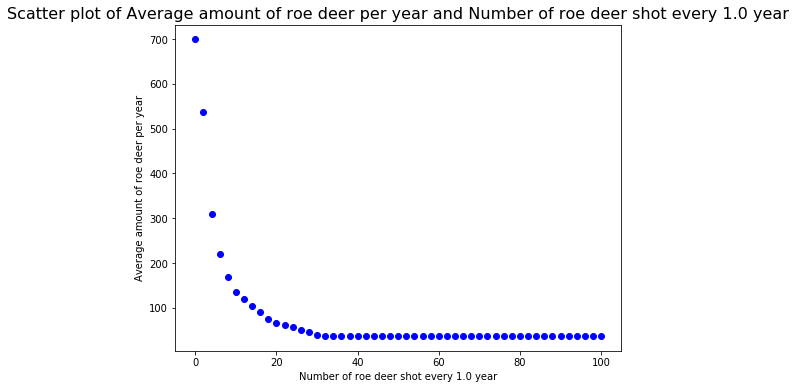

Significant correlation? True


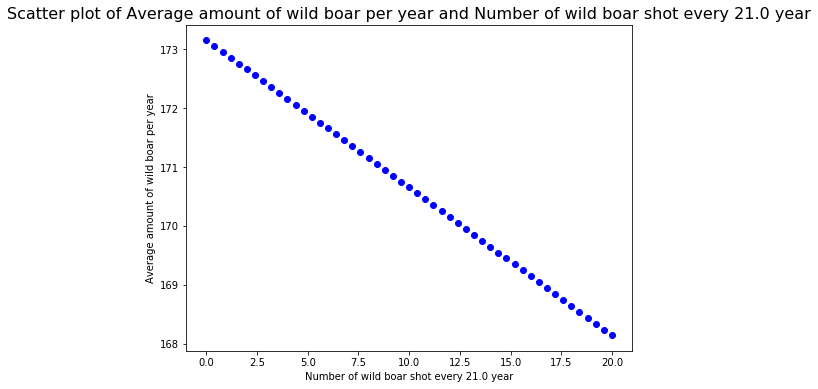

Significant correlation? True


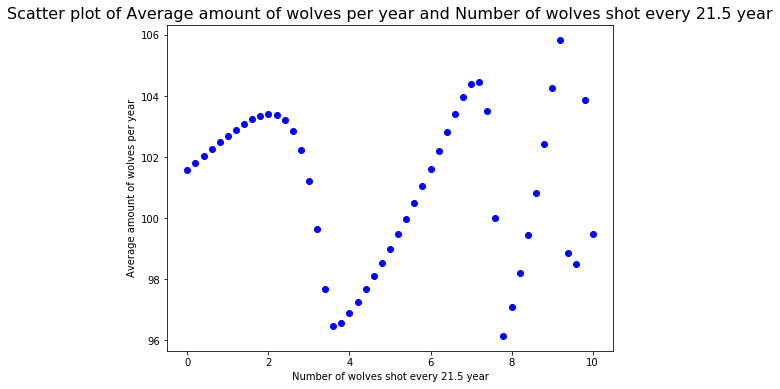

Significant correlation? False


In [18]:
# Make the parameters for shooting numbers of animals for the lotka-volterra function.
params_num = [init_wolf, init_deer, init_boar, step1, 365.25, 0, 'static', 'none', 'none', False, False, False]

# Make data points for the different species.
period_deer = params_num[4]
num_r, num_res_r = avg_animals_integrate(1, 0, 100, 50, params_num, t, type='num')  # Roe deer
params_num[6] = 'none'
params_num[7] = 'static'
params_num[4] = 21*365.25
period_boar = params_num[4]
num_b, num_res_b = avg_animals_integrate(2, 0, 20, 50, params_num, t, type='num')  # Wild boar
params_num[7] = 'none'
params_num[8] = 'static'
params_num[4] = 21.5*365.25
num_w, num_res_w = avg_animals_integrate(0, 0, 10, 50, params_num, t, type='num')  # Wolves

# Make scatter plots for the different species and check the significance of the correlation.
make_scatter_plot(num_r, num_res_r, 'Number of roe deer shot every %s year' % str(period_deer/365.25),
                  'Average amount of roe deer per year')
print('Significant correlation? %s' % test_significance(num_res_r, mean_deer))

make_scatter_plot(num_b, num_res_b, 'Number of wild boar shot every %s year' % str(period_boar/365.25),
                  'Average amount of wild boar per year')
print('Significant correlation? %s' % test_significance(num_res_b, mean_boar))

make_scatter_plot(num_w, num_res_w, 'Number of wolves shot every %s year' % str(params_num[4]/365.25),
                  'Average amount of wolves per year')
print('Significant correlation? %s' % test_significance(num_res_w, mean_wolf))

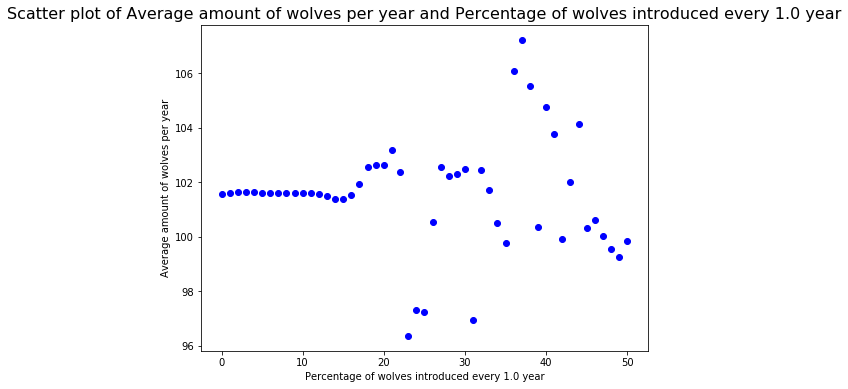

Significant correlation? False


In [19]:
# Make the parameters for percentage of wolves introduced.
params_wolf = [init_wolf, init_deer, init_boar, step1, 365.25, 0, 'none', 'none', 'none', True, False, False]

# Make data points for the different species.
wolf_num, wolf_res = avg_animals_integrate(0, 0, -50, 50, params_wolf, t)
wolf_num *= -1

# Plot the data and check if the correlation is significant.
make_scatter_plot(wolf_num, wolf_res, 'Percentage of wolves introduced every %s year' % str(params_wolf[4]/365.25),
                  'Average amount of wolves per year')
print('Significant correlation? %s' % test_significance(wolf_res, mean_wolf))

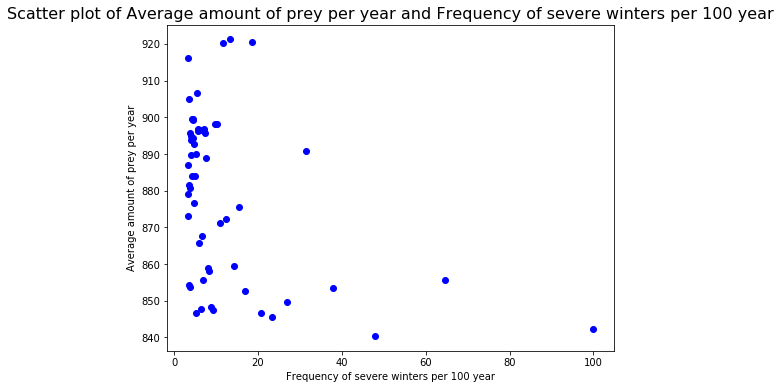

Significant correlation? True


In [20]:
# Make the parameters for frequency of severe winters. In severe winter growth is decreased with 9/10.
params_winter = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none',
                 False, True, False]

# Make data points for severe winter, where severe winters appear every 1-31 years.
per_win, tot_prey = avg_animals_winters(365.25, 31*365.25, 55, params_winter, t)
per_win = 100 / (per_win/365.25)

# Calculate mean, no events happening.
tot_mean = mean_deer + mean_boar

# Plot the data and check if the correlation is significant.
make_scatter_plot(per_win, tot_prey, 'Frequency of severe winters per 100 year',
                  'Average amount of prey per year')
print('Significant correlation? %s' % test_significance(tot_prey, tot_mean))